### Predicting Heartstroke 

The goal of this analysis is to be able to build a model by predicting whether or not someone will have a heartstroke

In [1]:
# Setting up environment
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import plotly.express as px
import numpy as np
from sklearn.metrics import classification_report
import statsmodels.formula.api as smf
from sklearn import metrics
import os
from statistics import mean
from math import isnan
from itertools import filterfalse
# Modeling Libraries
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split
from xgboost import XGBClassifier
import xgboost as xgb
import graphviz
from sklearn import tree
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [145]:
# os.chdir("E:\MSBA WINTER 23\BANA 288")

### Reading and setting up data

In [2]:
df = pd.read_csv('cleandata288.csv')

Visuals of raw dataset to get a better understanding of it

[Text(0, 0, '4861'), Text(0, 0, '249')]

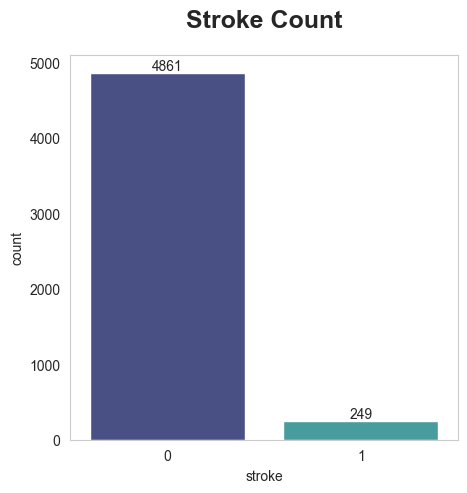

In [5]:
# This is the visuals for the raw dataset
# CountPlot of Work Type with Stroke
fig, ax = plt.subplots(figsize=(5, 5))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.countplot(data = df, x = 'stroke', palette="mako")
plt.title("Stroke Count", size=18, fontweight="bold", x=0.5, y=1.05)
ax.bar_label(ax.containers[0])


Text(0.5, 1.05, 'Stroke based on Age')

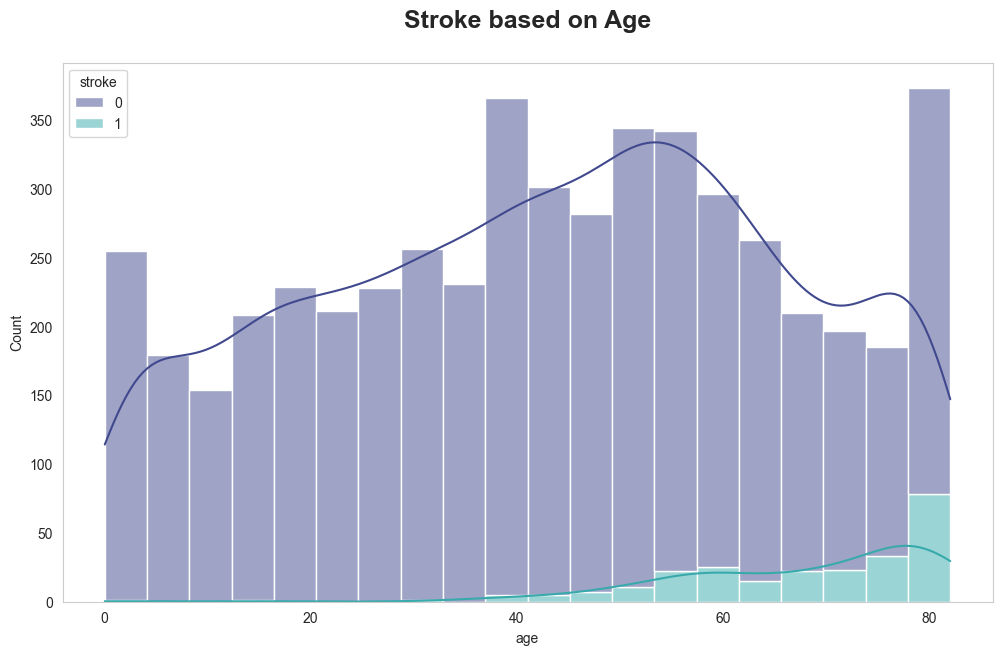

In [4]:
# Histogram of age with/without stroke
fig, ax = plt.subplots(figsize=(12, 7))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.histplot(data = df, x = 'age', palette="mako", hue="stroke", kde= True, multiple= "stack")
plt.title("Stroke based on Age", size=18, fontweight="bold", x=0.5, y=1.05)


[Text(0, 0, '1497'), Text(0, 0, '47')]

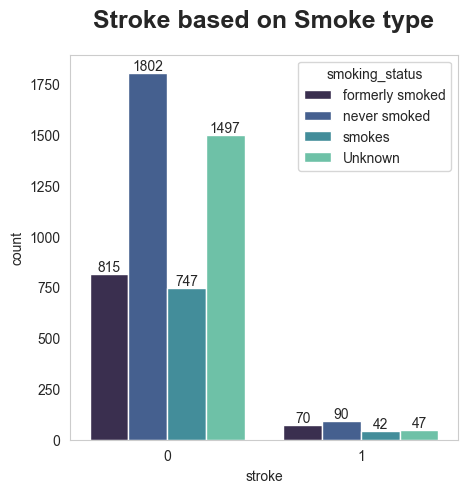

In [7]:
# Countplot of smoke type based on stroke 
fig, ax = plt.subplots(figsize=(5, 5))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.countplot(data = df, x = 'stroke', palette="mako", hue= "smoking_status")
plt.title("Stroke based on Smoke type", size=18, fontweight="bold", x=0.5, y=1.05)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
ax.bar_label(ax.containers[3])


This dataset has a lot of non-stroke rows, which has a 5% amount of datasets that come out to having a stroke.
We shall undersample the amount of nonstroke data rows in order to build a better model that will predict better.
Cleaning the data by replacing null values of BMI and renaming columns. Dataset has been pre-cleaned in R by replacing certain variables as binomial values (0 and 1) and developing dummy variables for other categories such as work type and smoking status

In [9]:
# Cleaning the data, replacing null values of BMI with average and dropping a column, renaming some columns
df.bmi = df.bmi.fillna(df.bmi.mean())
df = df.drop(["Residence_typeUrban"], axis= 1)
df = df.rename(columns= {"smoking_statusformerly.smoked": "smoking_statusformerlysmoked", "smoking_statusnever.smoked":"smoking_statusneversmoked","work_typeSelf.employed":"work_typeSelfemployed","gender":"male" })
display(df)

,id,male,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,...,work_typechildren,work_typeGovt_job,work_typeNever_worked,work_typePrivate,work_typeSelfemployed,Residence_typeRural,smoking_statusformerlysmoked,smoking_statusneversmoked,smoking_statussmokes,smoking_statusUnknown
0,9046,1,67.0,0,1,1,Private,Urban,228.69,36.600000,...,0,0,0,1,0,0,1,0,0,0
1,51676,0,61.0,0,0,1,Self-employed,Rural,202.21,28.893237,...,0,0,0,0,1,1,0,1,0,0
2,31112,1,80.0,0,1,1,Private,Rural,105.92,32.500000,...,0,0,0,1,0,1,0,1,0,0
3,60182,0,49.0,0,0,1,Private,Urban,171.23,34.400000,...,0,0,0,1,0,0,0,0,1,0
4,1665,0,79.0,1,0,1,Self-employed,Rural,174.12,24.000000,...,0,0,0,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,0,80.0,1,0,1,Private,Urban,83.75,28.893237,...,0,0,0,1,0,0,0,1,0,0
5106,44873,0,81.0,0,0,1,Self-employed,Urban,125.20,40.000000,...,0,0,0,0,1,0,0,1,0,0
5107,19723,0,35.0,0,0,1,Self-employed,Rural,82.99,30.600000,...,0,0,0,0,1,1,0,1,0,0
5108,37544,1,51.0,0,0,1,Private,Rural,166.29,25.600000,...,0,0,0,1,0,1,1,0,0,0


In [10]:
# shuffling data, making less count of non stroke data in order to get a better prediction, selecting a sample of 500 of nonstroke data
df1 = df
datashuffle = df1.sample(frac=1,random_state=4)
dfs = df1.loc[df1['stroke'] == 1]
dfns = df1.loc[df1['stroke'] == 0].sample(n= 500,random_state= 105)
df_final = pd.concat([dfs, dfns])
display(df_final) 

,id,male,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,...,work_typechildren,work_typeGovt_job,work_typeNever_worked,work_typePrivate,work_typeSelfemployed,Residence_typeRural,smoking_statusformerlysmoked,smoking_statusneversmoked,smoking_statussmokes,smoking_statusUnknown
0,9046,1,67.0,0,1,1,Private,Urban,228.69,36.600000,...,0,0,0,1,0,0,1,0,0,0
1,51676,0,61.0,0,0,1,Self-employed,Rural,202.21,28.893237,...,0,0,0,0,1,1,0,1,0,0
2,31112,1,80.0,0,1,1,Private,Rural,105.92,32.500000,...,0,0,0,1,0,1,0,1,0,0
3,60182,0,49.0,0,0,1,Private,Urban,171.23,34.400000,...,0,0,0,1,0,0,0,0,1,0
4,1665,0,79.0,1,0,1,Self-employed,Rural,174.12,24.000000,...,0,0,0,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,11999,0,63.0,0,0,1,Govt_job,Rural,79.92,28.893237,...,0,1,0,0,0,1,0,0,1,0
4192,33886,0,30.0,0,0,0,Private,Rural,87.12,31.100000,...,0,0,0,1,0,1,0,0,1,0
1046,5077,1,45.0,0,0,1,Private,Urban,76.72,29.100000,...,0,0,0,1,0,0,0,0,0,1
3636,2903,0,35.0,0,0,0,Private,Rural,123.83,23.800000,...,0,0,0,1,0,1,0,1,0,0


In [11]:
# Looking at descriptive statistics of finalized data
age_stats = df_final.age.describe()
print("The following shows the statistics for age:\n",age_stats)
res_stat = df_final.Residence_type.value_counts()
print("\nThe following shows the count for residency:\n",res_stat)
work_stat = df_final.work_type.value_counts()
print("\nThe following shows the count for work types:\n",work_stat)


The following shows the statistics for age:
 count    749.000000
mean      50.005127
std       22.587475
min        0.240000
25%       35.000000
50%       54.000000
75%       69.000000
max       82.000000
Name: age, dtype: float64

The following shows the count for residency:
 Urban    387
Rural    362
Name: Residence_type, dtype: int64

The following shows the count for work types:
 Private          431
Self-employed    159
Govt_job          85
children          71
Never_worked       3
Name: work_type, dtype: int64


Text(0.5, 1.0, 'BMI Boxplots of Stroke/No Stroke')

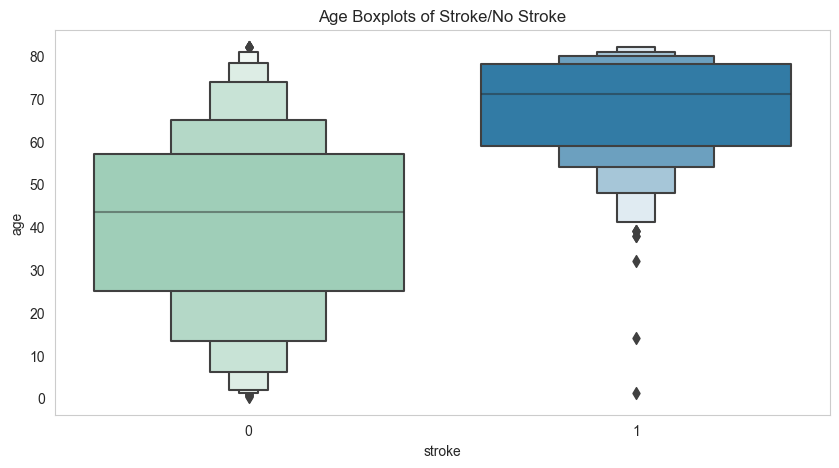

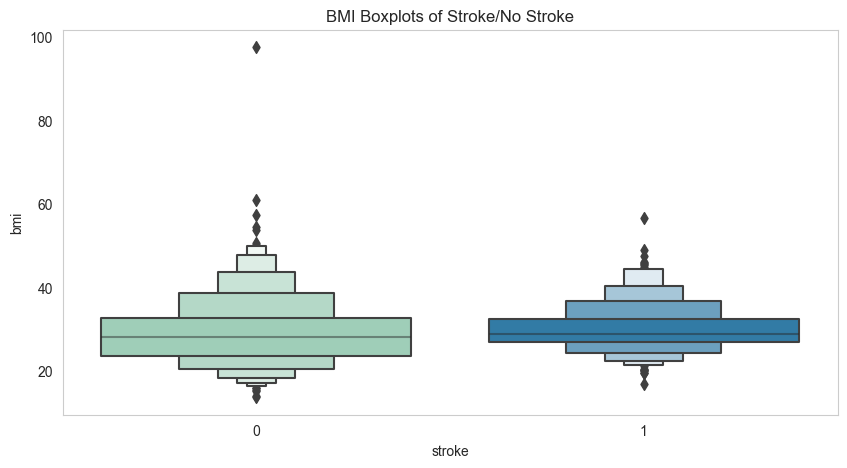

In [12]:
# Boxplot of Age of final dataset 
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.boxenplot(data = df_final, x = "stroke", y="age", palette= "YlGnBu")
plt.title("Age Boxplots of Stroke/No Stroke")
# Boxplot of bmi of final dataset 
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.boxenplot(data = df_final, x = "stroke", y="bmi", palette= "YlGnBu")
plt.title("BMI Boxplots of Stroke/No Stroke")

C:\Users\halan\AppData\Local\Temp\ipykernel_23792\2486729327.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_final.corr(),annot=True, cmap="YlGnBu")


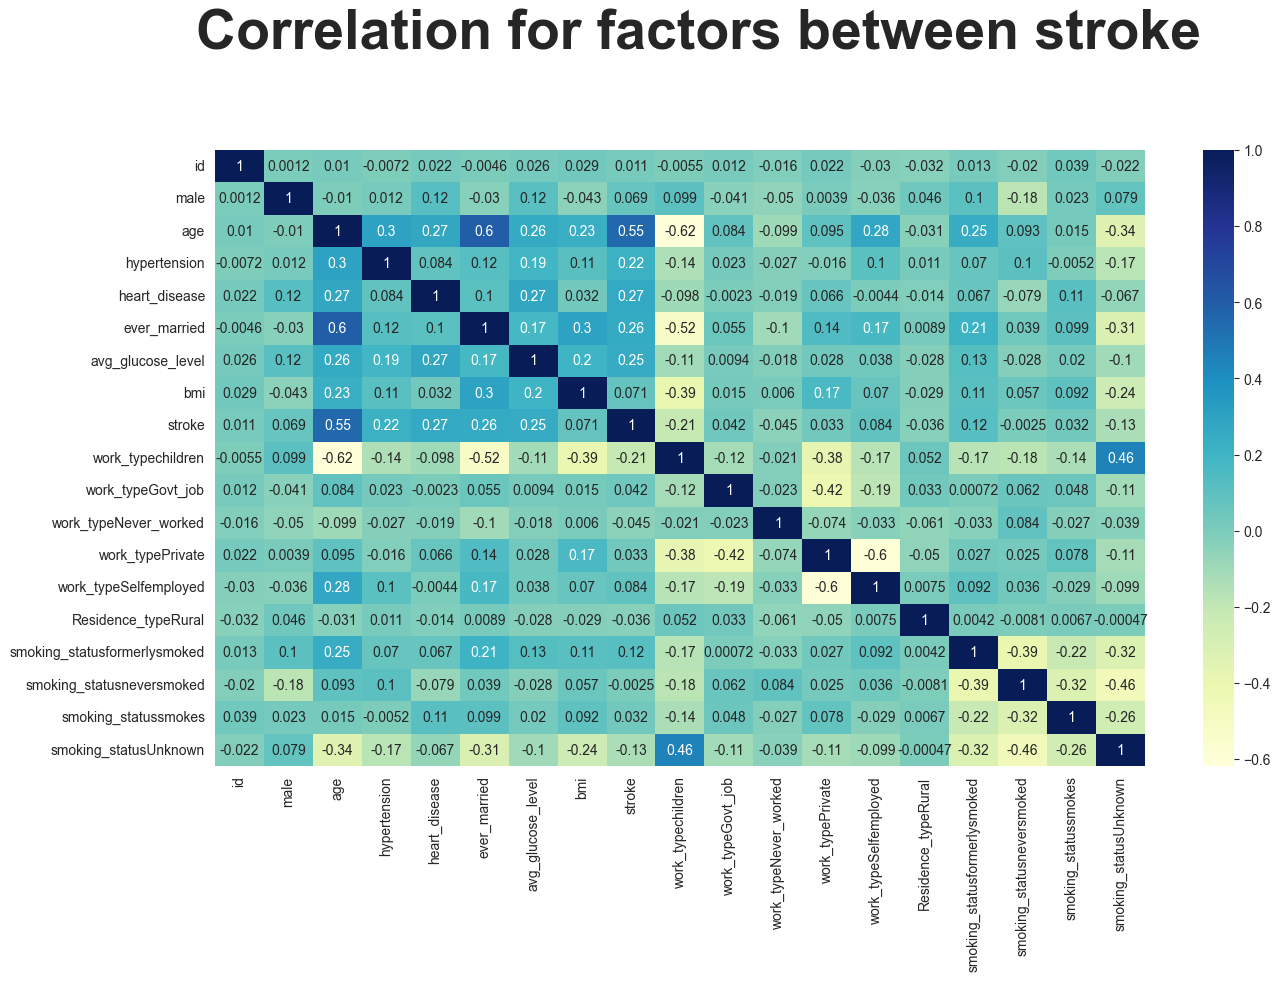

[Text(0, 0, '158'), Text(0, 0, '47')]

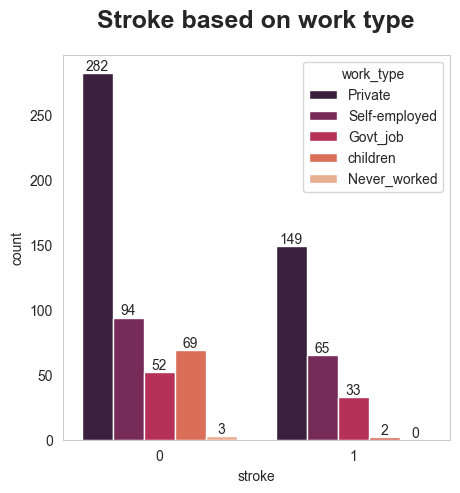

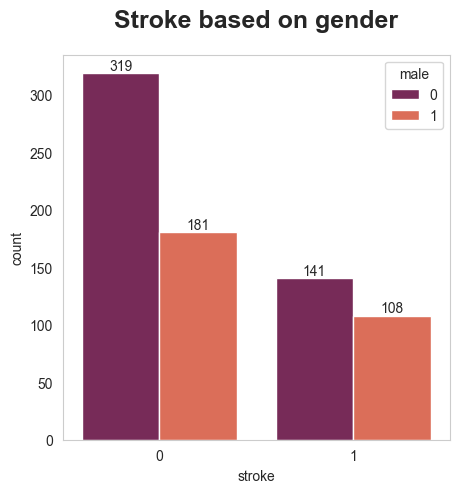

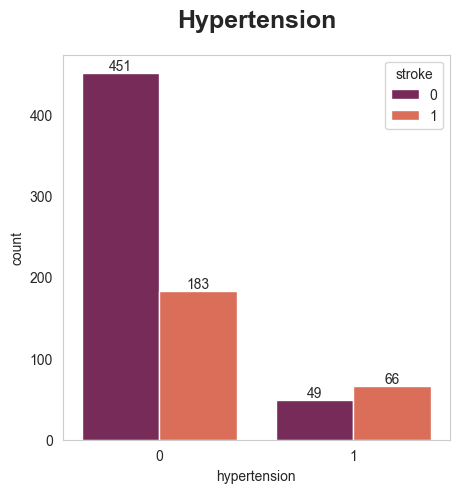

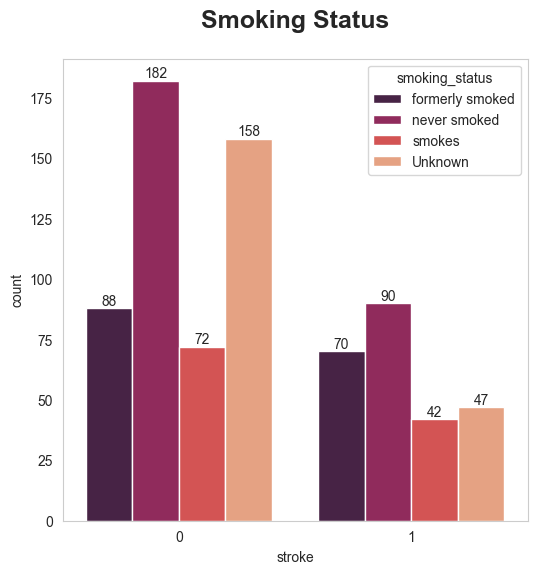

In [13]:
# These are the visuals for the finalized dataset 
# Correlation Map
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(df_final.corr(),annot=True, cmap="YlGnBu")
plt.title("Correlation for factors between stroke", fontsize=40, x=0.52, y=1.15, fontweight="bold")
plt.show()
# CountPlot of Work Type with Stroke
fig, ax = plt.subplots(figsize=(5, 5))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.countplot(data = df_final, x = 'stroke', palette="rocket", hue= "work_type")
plt.title("Stroke based on work type", size=18, fontweight="bold", x=0.5, y=1.05)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
ax.bar_label(ax.containers[3])
ax.bar_label(ax.containers[4])
# CountPlot of Married with Stroke
fig, ax = plt.subplots(figsize=(5, 5))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.countplot(data = df_final, x = 'stroke', palette="rocket", hue= "male")
plt.title("Stroke based on gender", size=18, fontweight="bold", x=0.5, y=1.05)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
# CountPlot of hypertension with Stroke
fig, ax = plt.subplots(figsize=(5, 5))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.countplot(data = df_final, x = 'hypertension', palette="rocket", hue= "stroke")
plt.title("Hypertension", size=18, fontweight="bold", x=0.5, y=1.05)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
# CountPlot of Smoking Status Type with Stroke
fig, ax = plt.subplots(figsize=(6,6))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.countplot(data = df_final, x = 'stroke', palette="rocket", hue= "smoking_status")
plt.title("Smoking Status", size=18, fontweight="bold", x=0.5, y=1.05)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
ax.bar_label(ax.containers[3])


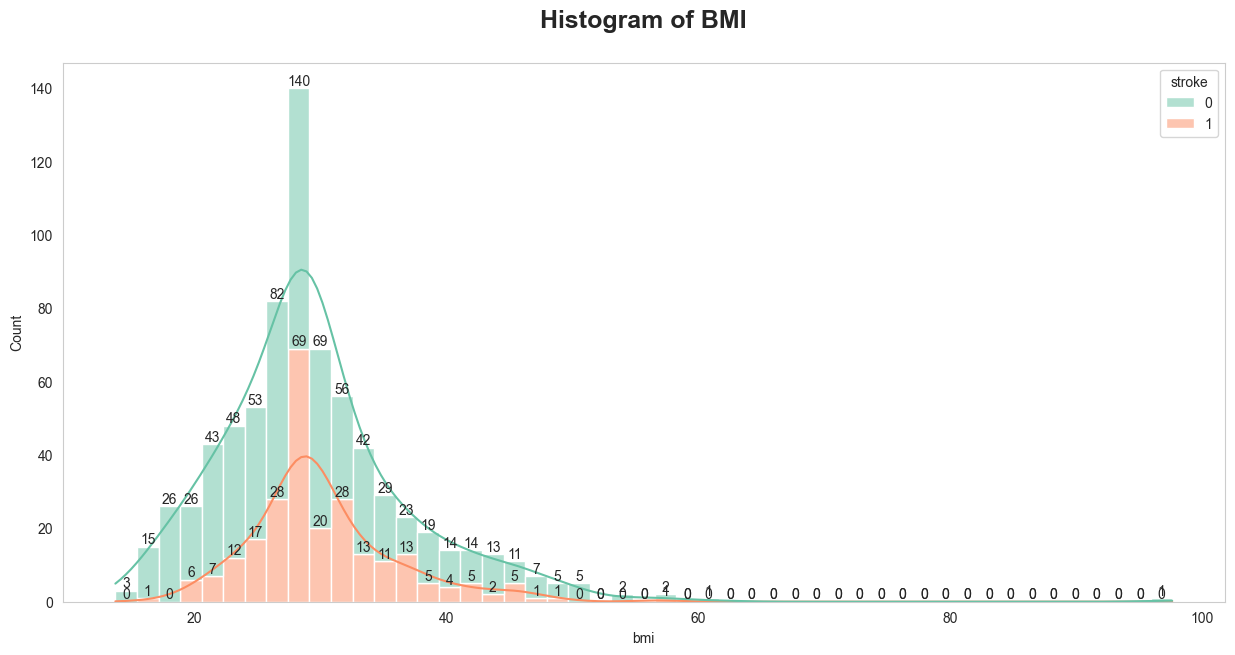

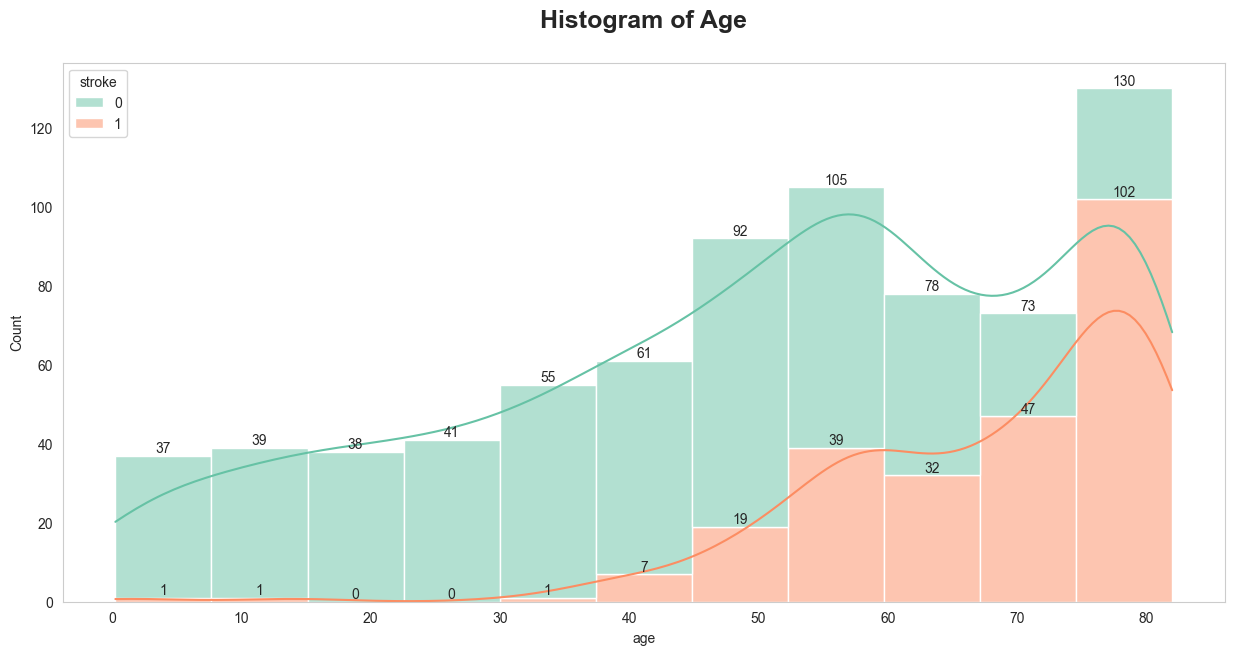

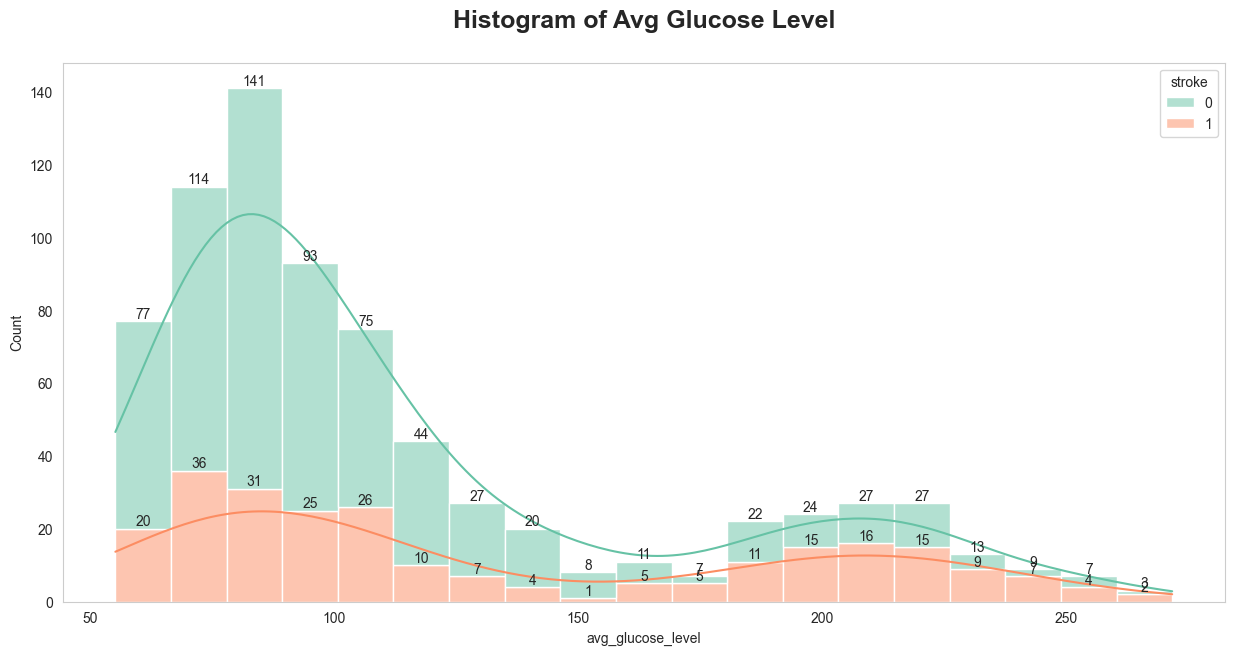

In [15]:
# Histogram of BMI with Stroke
fig, ax = plt.subplots(figsize=(15, 7))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.histplot(data = df_final, x = 'bmi', palette="Set2",hue="stroke", kde=True,multiple = "stack")
plt.title("Histogram of BMI", size=18, fontweight="bold", x=0.5, y=1.05)
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[0])
plt.show()
# Histogram of Age with Stroke
fig, ax = plt.subplots(figsize=(15, 7))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.histplot(data = df_final, x = 'age', palette="Set2",hue="stroke", kde=True,multiple = "stack")
plt.title("Histogram of Age", size=18, fontweight="bold", x=0.5, y=1.05)
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[0])
plt.show()
# Histogram of Avg Glucose Level with Stroke
fig, ax = plt.subplots(figsize=(15, 7))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.histplot(data = df_final, x = 'avg_glucose_level', palette="Set2",hue="stroke", kde=True,multiple = "stack")
plt.title("Histogram of Avg Glucose Level", size=18, fontweight="bold", x=0.5, y=1.05)
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[0])
plt.show()



### Setting up data for analysis:

In [33]:
# Setting up data: training/testing data split
y = df_final["stroke"]
x = df_final[["male","age","hypertension","heart_disease","ever_married","bmi","avg_glucose_level","work_typechildren", "work_typeGovt_job","work_typeNever_worked","work_typePrivate","work_typeSelfemployed",'smoking_statusformerlysmoked','smoking_statusneversmoked','smoking_statussmokes','smoking_statusUnknown',"Residence_typeRural"]]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=109)


### Logistic Regression Model

Logistic Regression classification report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.88       161
           1       0.70      0.73      0.72        64

    accuracy                           0.84       225
   macro avg       0.80      0.81      0.80       225
weighted avg       0.84      0.84      0.84       225



c:\Users\halan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


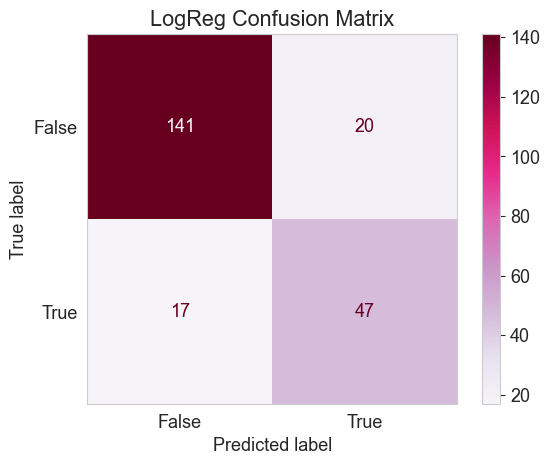

Logistic Regression accuracy: 0.84


,coef
male,0.430615
age,0.084259
hypertension,0.105889
heart_disease,-0.027427
ever_married,0.108170
bmi,-0.007127
avg_glucose_level,0.003966
work_typechildren,0.091273
work_typeGovt_job,-0.563607
work_typeNever_worked,-0.048831


In [50]:
#Logistic Regression Model 
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
# Classification report setup
print("Logistic Regression classification report:\n",classification_report(y_test,predictions))
logmodel.score(X_test,y_test)
y_pred=logmodel.predict(X_test)
# Confusion Matrix report setup
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot(cmap = "PuRd")
plt.title("LogReg Confusion Matrix")
plt.show()
# Accuracy Score and Coefficient display
acc1 = accuracy_score(y_test, y_pred)
print("Logistic Regression accuracy:",round(acc1,2))
coefdf = pd.DataFrame(logmodel.coef_.reshape(-1,1),x.columns, columns=['coef'])
display(coefdf)


The overall accuracy of the logistic regression is 0.84, and the following table above can be seen as an interpretation of how the variables influence the model. 
The f1 scores of 0.88 and 0.72 for predicting no stroke and stroke

### Decision Tree Analysis

In [20]:
# Decision Tree cross validation
parameters = {'max_depth':range(3,30)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=5)
clf.fit(X=X_train, y=y_train)
tree_model = clf.best_estimator_
print(clf.best_score_, clf.best_params_) # The decision tree score comes out best with a max depth of 3, so use for model


0.7497985347985348 {'max_depth': 3}


The following is a classification report of decision tree
               precision    recall  f1-score   support

           0       0.91      0.79      0.85       161
           1       0.60      0.81      0.69        64

    accuracy                           0.80       225
   macro avg       0.76      0.80      0.77       225
weighted avg       0.83      0.80      0.80       225

Decision Tree Accuracy 0.796


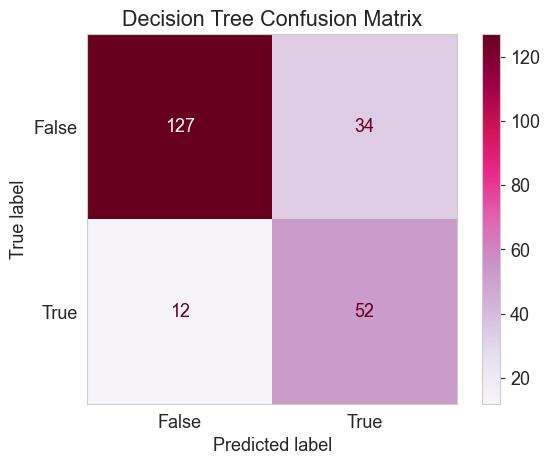

In [51]:
# Building Decision Tree Model 
dt_best = tree.DecisionTreeClassifier(max_depth=3) 
dt_best.fit(X_train, y_train)
ydpred = dt_best.predict(X_test)
# Setting up Classification Report
print("The following is a classification report of decision tree\n",classification_report(y_test,ydpred))
print("Decision Tree Accuracy",round(metrics.accuracy_score(y_test, ydpred),3))
# Setting up Confusion Matrix
cmdt = metrics.confusion_matrix(y_test, ydpred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cmdt, display_labels = [False, True])
cm_display.plot(cmap = "PuRd")
plt.title("Decision Tree Confusion Matrix")
plt.show()

Overall accuracy for Decision Tree is 0.796, with f1 scores of 0.85 and 0.69 for predicting no stroke and stroke

### Random Forest Classifier Model

Accuracy for RandomForestClassifier: 0.82
Classification report for RandomForestClassifier:
               precision    recall  f1-score   support

           0       0.89      0.86      0.87       161
           1       0.68      0.72      0.70        64

    accuracy                           0.82       225
   macro avg       0.78      0.79      0.79       225
weighted avg       0.83      0.82      0.82       225



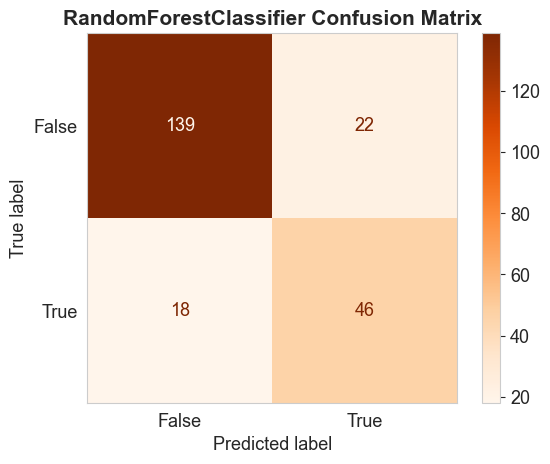

<Figure size 1000x1000 with 0 Axes>

In [55]:
# Random Forest Classifier Model
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
yrf_pred = rfc.predict(X_test)
# Reading accuracy and classification report for RFC
print("Accuracy for RandomForestClassifier:",round(accuracy_score(y_test,yrf_pred),2))
print("Classification report for RandomForestClassifier:\n",classification_report(y_test,yrf_pred))
# Setting up Confusion Matrix
cmr = metrics.confusion_matrix(y_test, yrf_pred)
cmrd = metrics.ConfusionMatrixDisplay(confusion_matrix = cmr, display_labels = [False, True])
cmrd.plot(cmap = "Oranges")
plt.rcParams.update({"font.size":13})
plt.title("RandomForestClassifier Confusion Matrix", size = 15, fontweight="bold")
plt.figure(figsize=(10,10))
plt.show()
# Looking at the feature importances based on Random Forest Classifier
importances = rfc.feature_importances_
feature_names = [f"feature {i}" for i in range(x.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)

Overall accuracy for Random Forest Classifier is is 0.82, with f1 scores of 0.87 and 0.70 for predicting no stroke and stroke

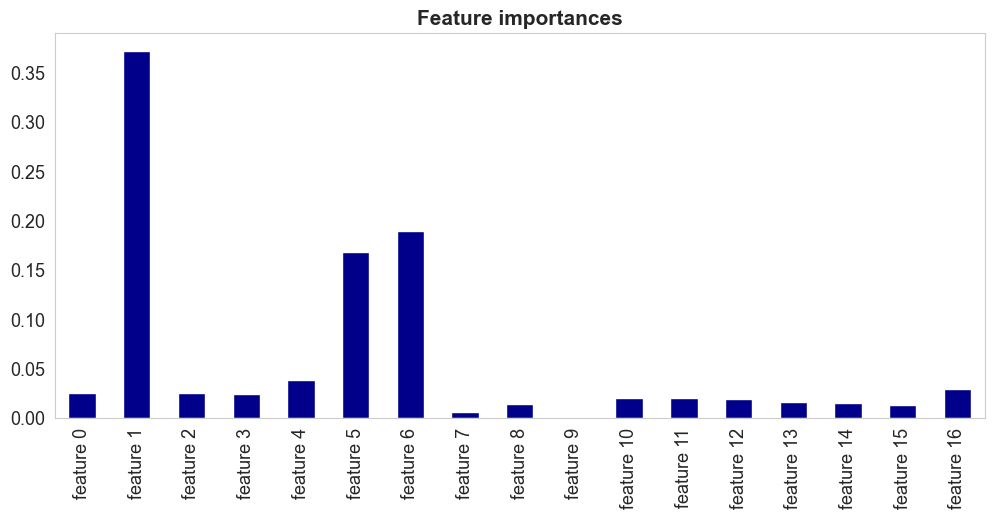

Index(['age', 'bmi', 'avg_glucose_level'], dtype='object')

In [56]:
# Feature importances from RFC
fig, ax = plt.subplots(figsize=(12,5))
forest_importances.plot.bar(ax=ax, color="DarkBlue")
plt.title("Feature importances", size = 15, fontweight="bold")
plt.show()
#Looking at top Three features for dataset
x.columns[[1,5,6]]


The age, BMI, and average glucose level have the highest importance in the random forest classifier model


Overall, predicting a heartstroke is difficult, but doable. There could be more variables that can be looked into ones health, such as blood pressure or family history in order to gain a higher prediction for the stroke. The models overall had fair accuracy.